In [25]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import time

## Se carga el dataset previamente porcesado en bash

In [33]:
# Primer paso: Jalar el dataset procesado por el archivo de file.

caravan = pd.read_csv("../../ticdata2000_wh.txt", sep = "|")
caravan.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


## Se hizo la selección de siete variables basado en la slección de variables hecha en [esta](https://medium.com/swlh/feature-selection-to-kaggle-caravan-insurance-challenge-on-r-bede801d3a66) liga.



In [34]:
#Seleccionamos las variables más importantes. 

caravan = caravan.iloc[:,[17, 40, 46, 57, 58, 81, 82, 85]]

In [35]:
missings_prop = caravan.apply(lambda x: round(x.isnull().sum()/caravan.shape[0]*100, 2))
missings_numeric_caravan = pd.DataFrame({'proporcion_de_valores_faltantes': missings_prop})
missings_numeric_caravan

,proporcion_de_valores_faltantes
MOPLLAAG,0.0
MINK123M,0.0
PPERSAUT,0.0
PWAOREG,0.0
PBRAND,0.0
APLEZIER,0.0
AFIETS,0.0
CARAVAN,0.0


In [36]:
# No se encuntran NA's en el dataset.

missings_numeric_caravan[missings_numeric_caravan.proporcion_de_valores_faltantes != 0].count()

proporcion_de_valores_faltantes    0
dtype: int64

(array([1., 1., 1., 1., 1., 0., 1., 2.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 8 artists>)

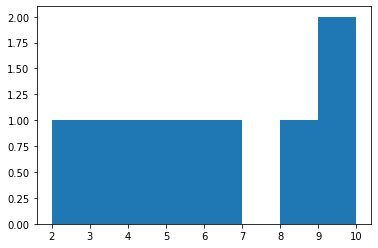

In [ ]:
u_values = pd.Series({c: caravan[c].nunique(dropna=True) for c in caravan})

plt.hist(u_values, bins=8)

In [43]:
# Definimos la función que probara algunos modelos para nuestro conjunto de datos.

def model(df_train_test):
    # Funciones para regresar el DataFrame con las etiquetas y los sets de entrenamiento y 
    # y prueba a los cuatro DF X_train, X_test, Y_train, .Y_test
    label = df_train_test.iloc[:,-1]
    dataset = df_train_test.iloc[:,:-1]
    
    X_train, X_test, y_train, y_test = train_test_split(dataset, label)       
    # Algoritmos a evaluar: DecisionTree y RandomForest
    algorithms_dict = {'tree': 'tree_grid_search'}
    algorithms = ['tree']
    # Hiperparámetros a evaluar en cada algoritmo:
    grid_search_dict = {'tree_grid_search': {'max_depth': [5,10,15], 
                                         'min_samples_leaf': [3,5,7]}}
    # Configuraciones generales de cada algoritmo a evaluar:
    estimators_dict = {'tree': DecisionTreeClassifier(random_state=1111)}
    best_estimators = []
    # Magic loop
    tscv = TimeSeriesSplit(n_splits=3)
    start_time = time.time()
    for algorithm in algorithms:
        estimator = estimators_dict[algorithm]
        grid_search_to_look = algorithms_dict[algorithm]
        grid_params = grid_search_dict[grid_search_to_look]
        gs = GridSearchCV(estimator, grid_params, scoring='precision', cv=tscv, n_jobs=-1)
        #train
        gs.fit(X_train, y_train)
        #best estimator
        best_estimators.append(gs)
    
    # MEtadata:
    # Mejor modelo de árbol
    best_tree = best_estimators[0].best_estimator_
    # Tiempo de ejecución
    t_exec = time.time() - start_time
    # Información de los modelos considerados en la selección
    r = pd.DataFrame(best_estimators[0].cv_results_)
    r = r.sort_values("rank_test_score")
    lista = r.params.astype(str)
    test_mod = "|".join(lista)
    lista_2 = r.mean_test_score.astype(str)
    mean_scores = "|".join(lista_2)
    lista_3 = r.rank_test_score.astype(str)
    rank_model = "|".join(lista_3)
    # Persistir mejor modelo en .pkl
    obj_model = best_tree.fit(X_train, y_train)
#    pickle.dump(best_tree, open("best_model.pkl", 'wb'))
#    model_pkl = pickle.load(open("best_model.pkl","rb"))
    return obj_model, str(best_tree), t_exec, test_mod, mean_scores, rank_model

In [44]:
obj_model, best_tree, t_exec, test_mod, mean_scores, rank_model = model(caravan)

In [45]:
caravan.value_counts()

MOPLLAAG  MINK123M  PPERSAUT  PWAOREG  PBRAND  APLEZIER  AFIETS  CARAVAN
5         0         0         0        0       0         0       0          203
6         0         0         0        0       0         0       0          153
5         0         6         0        0       0         0       0          140
4         0         0         0        0       0         0       0          138
6         0         6         0        0       0         0       0          129
                                                                           ... 
4         0         0         5        2       0         0       0            1
                              0        4       1         0       1            1
                                               0         1       0            1
                                       3       0         0       1            1
9         2         0         0        2       0         0       0            1
Length: 658, dtype: int64

In [ ]:
profile = ProfileReport(caravan)
profile.to_file(output_file='data_profiling.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 317.56it/s]
